# Question 1

### Exercise 1.(b)

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

# Load the pretrained model from pytorch
alexnet = models.alexnet(weights= models.AlexNet_Weights.DEFAULT)
alexnet.eval()





AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

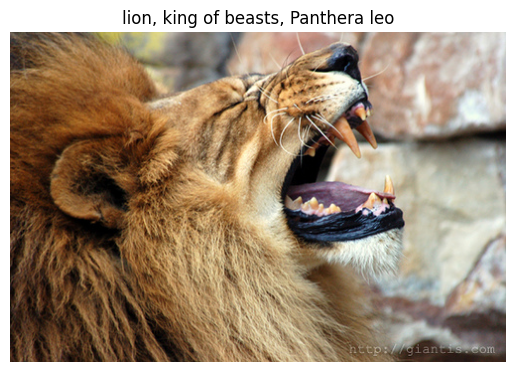

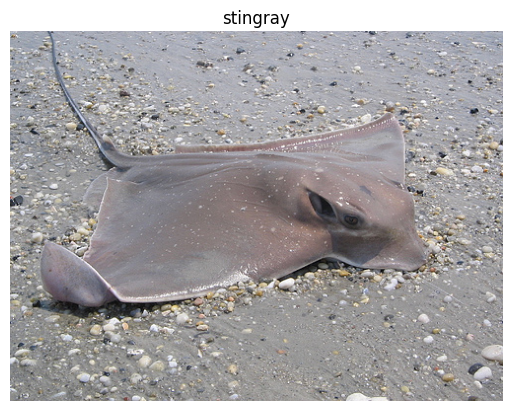

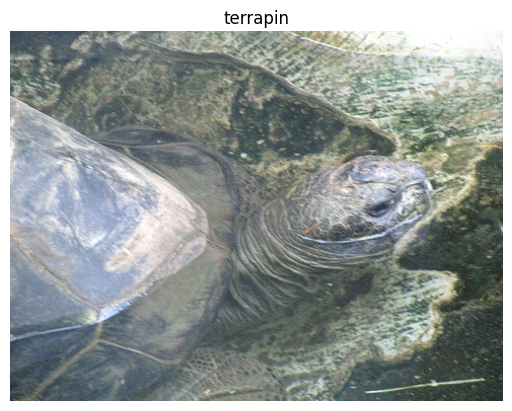

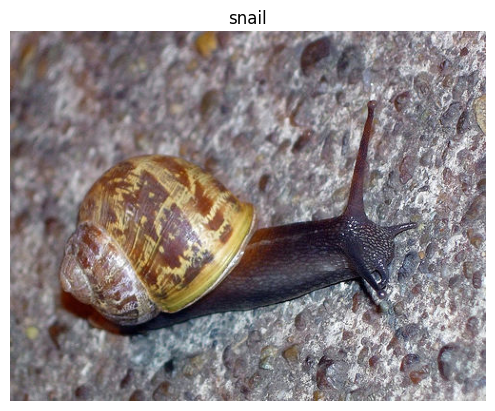

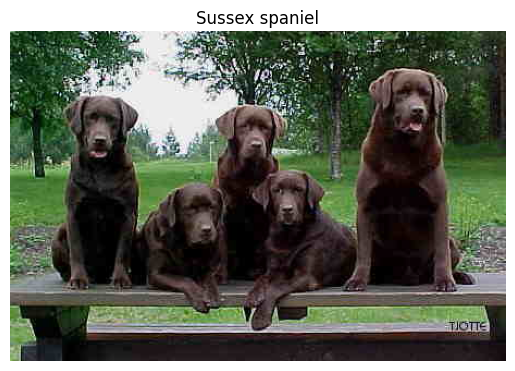

In [29]:
import requests
import ast
from PIL import Image
from io import BytesIO


# Load labels
class_labels_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
response = requests.get(class_labels_url)
class_label_dict = ast.literal_eval(response.text)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# prediction function , get the top predicted class
def predict(imgurl, model):
    response = requests.get(imgurl)
    img = Image.open(BytesIO(response.content))
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    model.eval()
    with torch.no_grad():
        out = model(batch_t)
    _, top_pred = torch.topk(out, 1)
    top_pred = top_pred.item()
    label = class_label_dict[top_pred]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
    plt.show()

# Load the image
list_of_images = ["https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02129165_19260_lion.jpg", 
                  "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n01495701_1216_ray.jpg",
                    "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n01662784_3789_turtle.jpg",
                    "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n01944390_7816_snail.jpg",
                    "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02084071_19639_dog.jpg"


                  ]

for img in list_of_images:
    predict(img, alexnet)



    










In [31]:
import random
import torch.optim as optim

def preprocess_image(img):
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t

# Create adversarial examples
def create_adversarial_example(img, target_class, model, alpha, learning_rate, max_iter = 1000):
    img_var = img.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([img_var], lr=learning_rate)
    target_class_var = torch.LongTensor([target_class])
    for i in range(max_iter):
        optimizer.zero_grad()
        out = model(img_var)
        loss = alpha * torch.norm(img_var-img , p =1)+ torch.nn.CrossEntropyLoss()(out, target_class_var)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print("Iteration: {}, Loss: {}".format(i, loss.item()))
        _, top_pred = torch.topk(out, 1)
        if top_pred.item() == target_class:
            break
    return img_var.detach()

random_sample_image = ["https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02219486_21998_ant.jpg",
                       "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02324045_13467_rabbit.jpg"]

alpha = 10
learning_rate = 0.01
max_iter = 1000

for img in random_sample_image:
    response = requests.get(img)
    img = Image.open(BytesIO(response.content))
    img_t = preprocess_image(img)
    with torch.no_grad():
        true_class = torch.argmax(alexnet(img_t)).item()
    target_classes = random.sample([i for i in range(1000) if i != true_class], 3)
    print ("Original image: ")
    predict(img, alexnet)
    for target_class in target_classes:
        adversial_example = create_adversarial_example(img_t, target_class, alexnet, alpha, learning_rate, max_iter)
        adversial_example_img = transforms.ToPILImage()(adversial_example.squeeze(0))
        print (f"Adversarial example for target class {class_label_dict[target_class]}")
        predict(adversial_example_img, alexnet)





Original image: 


MissingSchema: Invalid URL '<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x308 at 0x1D12D08B580>': No scheme supplied. Perhaps you meant https://<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x308 at 0x1D12D08B580>?